# Retraining of the network

Use the already trained network as starting point and retrain it with new data to be more performant on this type of data

## Choose the retraining parameters

In [ ]:
talkative = True  ## print info messages

from dextrusion.DialogParameters import DialogParameters
diag = DialogParameters()
diag.dialog_retrain()

nepochs = int(diag.epochs)
naug = float(diag.aug)
modeldir = diag.modelf
path = diag.path
validation_ratio = float(diag.ratio)

# The new model will be saved in the same directory as previous model with same name + "retrained"
newmodelpath = modeldir+'_retrained0821/'

In [ ]:
talkative = True
nepochs = 60
naug = 5.0
modeldir = "/Users/yuyangsmacbook/project/dextrusion-main/DeXNets/notum_all/notum_all_original/notumAll0"
path = "/Users/yuyangsmacbook/Desktop/annotation_400+600+600"
validation_ratio = 0.2
batch_size_gui = 100
image_scaling_um = 0.275
newmodelpath = modeldir + "_retrained0910_466pure_0/"


## Load the previous network

In [18]:
from dextrusion.DeXtrusion import DeXtrusion
dexter = DeXtrusion(verbose=talkative)
dexter.load_model(modeldir)
dexter.retrain_parameters( model_path=newmodelpath, datapath=path, aug=naug, epoch=nepochs )

Tensorflow with Cuda: False
Tensorflow version: 2.15.0
Num GPUs Available:  0


## Load training and validation data

In [19]:
from dextrusion.MovieGeneratorFromROI import MovieGeneratorFromROI
train = MovieGeneratorFromROI(
                 data_path = path,
                 batch_size=dexter.batch_size,
                 frame_shape=dexter.nframes,
                 win_halfsize = dexter.half_size,
                 val_ratio=validation_ratio,
                 balance=True,
                 ncat=dexter.ncat,
                 cat_names = dexter.catnames,
                 naug=naug,
                 augment_withnoise=True,
                 add_nothing_windows=2,
                 nothing_factor=1.2,
                 verbose=talkative)

if talkative:
    print("Training size: "+str(train.__len__()*dexter.batch_size))
    print("Nb of batchs: "+str(train.__len__()))

valid = train.get_validation_generator()
if talkative:
    print("Validation size: "+str(valid.__len__()*dexter.batch_size))
print(f"half_size (hy, hx)     = {dexter.half_size}")

Found files: 
/Users/yuyangsmacbook/Desktop/annotation_400+600+600/049_100.tif
Nrois 1000.0
Training size: 8750
Nb of batchs: 175
Validation size: 2150
half_size (hy, hx)     = (22, 22)


### ReTrain the network, and save it

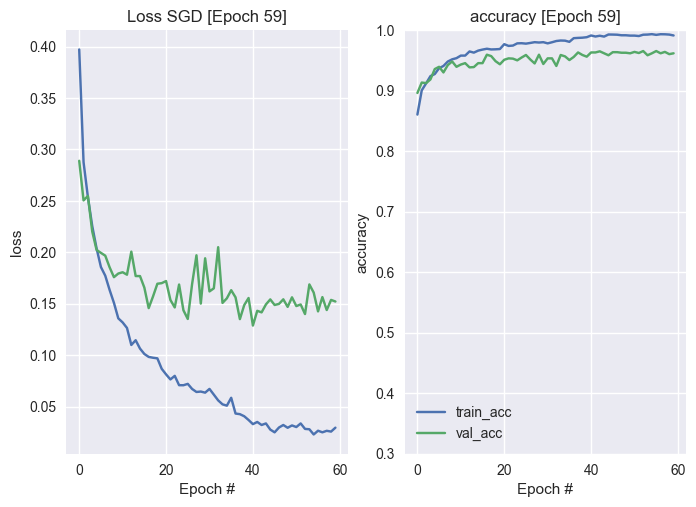

175/175 [==============================] - 42s 238ms/step - loss: 0.0297 - acc: 0.9913 - val_loss: 0.1523 - val_acc: 0.9619 - lr: 1.0000e-03
----- Training in 41.15255477825801 minutes ----
INFO:tensorflow:Assets written to: /Users/yuyangsmacbook/project/dextrusion-main/DeXNets/notum_all/notum_all_original/notumAll0_retrained0910_4610_0/assets


INFO:tensorflow:Assets written to: /Users/yuyangsmacbook/project/dextrusion-main/DeXNets/notum_all/notum_all_original/notumAll0_retrained0910_4610_0/assets


In [20]:
dexter.train_model(train_generator=train, validation_generator=valid, epochs=nepochs)  ## launch the retraining and save the new network
train.clean_tempdir()  ## remove the created files used for the training and validation

In [13]:
print("len(train) =", len(train)) 
print("batch_size =", dexter.batch_size)
print("n_train_windows =", len(train.trainindex))
print("n_val_windows   =", len(train.valindex)) 
print("check:", len(train.trainindex) // dexter.batch_size)


len(train) = 61
batch_size = 50
n_train_windows = 3097
n_val_windows   = 774
check: 61


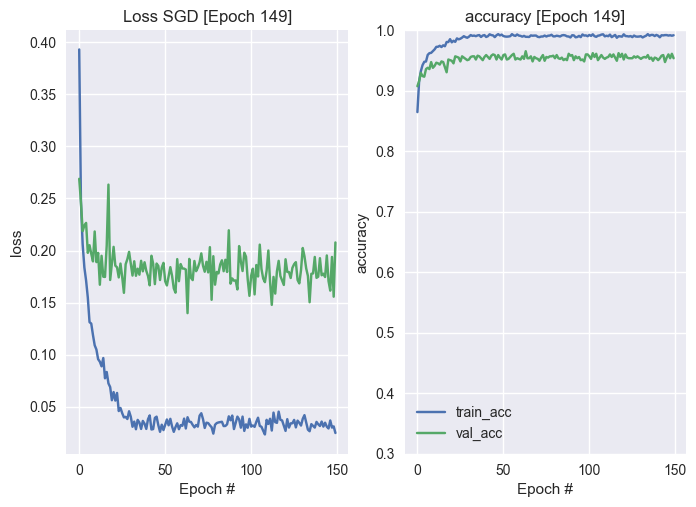

INFO:tensorflow:Assets written to: /Users/yuyangsmacbook/project/dextrusion-main/DeXNets/notum_all/notum_all_original/notumAll1_retrained0821/epoch150/assets


INFO:tensorflow:Assets written to: /Users/yuyangsmacbook/project/dextrusion-main/DeXNets/notum_all/notum_all_original/notumAll1_retrained0821/epoch150/assets


[checkpoint] saved: /Users/yuyangsmacbook/project/dextrusion-main/DeXNets/notum_all/notum_all_original/notumAll1_retrained0821/epoch150
77/77 [==============================] - 20s 261ms/step - loss: 0.0248 - acc: 0.9917 - val_loss: 0.2077 - val_acc: 0.9537 - lr: 1.0000e-13
----- Training in 45.88088746865591 minutes ----
INFO:tensorflow:Assets written to: /Users/yuyangsmacbook/project/dextrusion-main/DeXNets/notum_all/notum_all_original/notumAll1_retrained0821/assets


INFO:tensorflow:Assets written to: /Users/yuyangsmacbook/project/dextrusion-main/DeXNets/notum_all/notum_all_original/notumAll1_retrained0821/assets


In [69]:
# ===== 每隔 N 个 epoch 额外保存完整 SavedModel 的“零侵入”方案 =====
import os, shutil
import tensorflow as tf

# 你要的保存频率（比如每 10 个 epoch）
SAVE_EVERY = 10

# 基础输出目录：用你 retrain 时的 newmodelpath（例如 ".../notumAll0_retrained/"）
BASE_DIR = newmodelpath

# 定义一个最小回调：在 epoch 结束时把完整模型存成 SavedModel 目录
class SaveFullModelEveryN(tf.keras.callbacks.Callback):
    def __init__(self, base_dir, every=10, verbose=True):
        super().__init__()
        self.base_dir = base_dir
        self.every = int(every) if every is not None else None
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs=None):
        # epoch 是 0-based；+1 更直观
        e = epoch + 1
        if self.every is None or self.every <= 0:
            return
        # 到达指定间隔就存；最后一轮也会存
        if (e % self.every == 0) or (e == self.params.get("epochs", e)):
            outdir = os.path.join(self.base_dir, f"epoch{e:03d}")
            # 覆盖同名目录（可按需改成跳过）
            if os.path.isdir(outdir):
                shutil.rmtree(outdir)
            # 保存完整 SavedModel（目录结构：assets/, variables/, saved_model.pb）
            # 注意：self.model 是 Keras 回调里注入的当前模型
            self.model.save(outdir, save_format="tf")
            if self.verbose:
                print(f"[checkpoint] saved: {outdir}")

# 实例化回调
_ckpt_cb = SaveFullModelEveryN(BASE_DIR, every=SAVE_EVERY, verbose=True)

# --- 关键：给当前模型的 fit 打一个“猴子补丁”，把我们的回调自动追加进去 ---
# 要求：此时 dexter.model.model 已经存在（通常在 load_model/retrain_parameters 之后）
_orig_fit = dexter.model.model.fit

def _fit_with_extra_callback(*args, **kwargs):
    cbs = list(kwargs.get("callbacks", []))
    cbs.append(_ckpt_cb)
    kwargs["callbacks"] = cbs
    return _orig_fit(*args, **kwargs)

dexter.model.model.fit = _fit_with_extra_callback
# -------------------------------------------------------------------------

# 之后像平时一样一次性开训：曲线/日志“连续”，且每 10 epoch 会多一个完整模型目录
dexter.train_model(train_generator=train,
                   validation_generator=valid,
                   epochs=nepochs)

# （可选）你原先的清理缓存
train.clean_tempdir()


In [71]:
import os, shutil

root = "/Users/yuyangsmacbook/project/dextrusion-main/DeXNets/notum_all/notum_all_original/notumAll1_retrained0821"
for sub in os.listdir(root):
    d = os.path.join(root, sub)
    if os.path.isdir(d) and sub.startswith("epoch"):
        src = os.path.join(root, "config.cfg")
        dst = os.path.join(d, "config.cfg")
        if os.path.isfile(src):
            shutil.copy2(src, dst)
            print("copied:", dst)


copied: /Users/yuyangsmacbook/project/dextrusion-main/DeXNets/notum_all/notum_all_original/notumAll1_retrained0821/epoch140/config.cfg
copied: /Users/yuyangsmacbook/project/dextrusion-main/DeXNets/notum_all/notum_all_original/notumAll1_retrained0821/epoch060/config.cfg
copied: /Users/yuyangsmacbook/project/dextrusion-main/DeXNets/notum_all/notum_all_original/notumAll1_retrained0821/epoch050/config.cfg
copied: /Users/yuyangsmacbook/project/dextrusion-main/DeXNets/notum_all/notum_all_original/notumAll1_retrained0821/epoch010/config.cfg
copied: /Users/yuyangsmacbook/project/dextrusion-main/DeXNets/notum_all/notum_all_original/notumAll1_retrained0821/epoch080/config.cfg
copied: /Users/yuyangsmacbook/project/dextrusion-main/DeXNets/notum_all/notum_all_original/notumAll1_retrained0821/epoch020/config.cfg
copied: /Users/yuyangsmacbook/project/dextrusion-main/DeXNets/notum_all/notum_all_original/notumAll1_retrained0821/epoch130/config.cfg
copied: /Users/yuyangsmacbook/project/dextrusion-main/D

In [14]:
import numpy as np

def counts_by_class(gen, use_trainindex=True):
    idx = gen.trainindex if use_trainindex else np.arange(len(gen.catlist))
    cats = np.array([gen.catlist[i] for i in idx])
    return {int(c): int((cats == c).sum()) for c in np.unique(cats)}, len(cats)

train_counts, n_train_true = counts_by_class(train)
val_counts,   n_val_true   = counts_by_class(valid)

print("train counts per class:", train_counts)
print("val   counts per class:", val_counts)
print("true  train size:", n_train_true)
print("true  val   size:", n_val_true)
print("shown train size (batches*batch):", len(train)*train.batch_size)
print("shown val   size (batches*batch):", len(valid)*valid.batch_size)
print("train.nothing =", getattr(train, "nothing", "attr-missing"))
print("valid.nothing =", getattr(valid, "nothing", "attr-missing"))



train counts per class: {0: 2125, 1: 807, 3: 949}
val   counts per class: {0: 506, 1: 213, 3: 251}
true  train size: 3881
true  val   size: 970
shown train size (batches*batch): 3850
shown val   size (batches*batch): 950
train.nothing = 1.2
valid.nothing = 1.2
